## CMPE462: MACHINE LEARNING TERM PROJECT

### Authors :
*   Nazlıcan Aka - 2020400027
*   Aslı Gök - 2020400189
*   Dağlar Eren Tekşen - 2020400111


## Task 1: Data Collection and Feature Extraction

In [12]:
import json
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def parse_awards(awards):
    """Extract the number of wins and nominations from the Awards field."""
    wins = re.search(r"(\d+) win", awards)
    nominations = re.search(r"(\d+) nomination", awards)
    total_wins = int(wins.group(1)) if wins else 0
    total_nominations = int(nominations.group(1)) if nominations else 0
    return total_wins, total_nominations

def extract_features_from_json(json_data):
    """Extract features from the given JSON movie data."""
    features = []
    for movie in json_data:
        # Year
        year = int(movie.get('Year', '0'))

        # Runtime
        runtime_str = movie.get('Runtime', '0 min')
        runtime = int(runtime_str.split()[0]) if runtime_str.split()[0].isdigit() else 0

        # Genre
        genres = movie.get('Genre', '').split(', ')
        num_genres = len(genres)

        # Director
        # director = movie.get('Director', 'Unknown')

        # Writer
        # writer = movie.get('Writer', 'Unknown')

        # Number of actors
        num_actors = len(movie.get('Actors', '').split(', '))

        # Language
        languages = movie.get('Language', '').split(', ')
        # number of languages
        num_languages = len(languages)

        # Country
        country = movie.get('Country', 'Unknown')
        # number of countries
        num_countries = len(country)

        # Awards
        awards = movie.get('Awards', '')
        wins, nominations = parse_awards(awards)

        # Metascore
        # metascore = int(movie.get('Metascore', '0')) if movie.get('Metascore', 'N/A') != 'N/A' else 0

        # BoxOffice
        box_office_str = movie.get('BoxOffice', '$0').replace('$', '').replace(',', '')
        box_office = int(box_office_str) if box_office_str.isdigit() else 0

        # IMDb Rating
        imdb_rating = float(movie.get('imdbRating', '0.0')) if movie.get('imdbRating', 'N/A') != 'N/A' else 0.0

        # Append extracted features
        features.append({
            'Title': movie.get('Title', ''),
            'Year': year,
            'Runtime': runtime,
            'NumGenres': num_genres,
            'Genres': genres,
            'NumActors': num_actors,
            'Languages': languages,
            'NumLanguages': num_languages,
            'NumCountries': num_countries,
            'Country': country,
            'Wins': wins,
            'Nominations': nominations,
            'BoxOffice': box_office,
            'IMDBRating': imdb_rating,
        })

    return pd.DataFrame(features)

# Load JSON data
json_file_path = "film_responses.json"  # Replace with your actual file path
with open(json_file_path, 'r', encoding='utf-8') as file:
    movie_data = json.load(file)

# Extract features
df = extract_features_from_json(movie_data)

# Drop rows with missing or zero IMDb ratings
df = df[df['IMDBRating'] > 0.0]
df.reset_index(drop=True, inplace=True)

# df = df[df['BoxOffice'] > 0.0]
# df.reset_index(drop=True, inplace=True)

# Add binary classification target (Good = 1, Bad = 0 based on IMDb rating)
df['Target'] = (df['IMDBRating'] > 7).astype(int)

df_all = pd.DataFrame() # df_all icinde IMDBRating sütunu da var
df_all = df
# Drop the 'IMDBRating' column from the DataFrame
df = df.drop(columns=['IMDBRating'])


# Display the resulting DataFrame
print(df.head())

               Title  Year  Runtime  NumGenres                   Genres  \
0  We Live in Public  2009       91          1            [Documentary]   
1   The Intouchables  2011      112          2          [Comedy, Drama]   
2         Swept Away  2002       89          2        [Comedy, Romance]   
3           Kick-Ass  2010      117          3  [Action, Comedy, Crime]   
4       12 Angry Men  1957       96          2           [Crime, Drama]   

   NumActors                  Languages  NumLanguages  NumCountries  \
0          3                  [English]             1            13   
1          3          [French, English]             2             6   
2          3  [English, Greek, Italian]             3            21   
3          3                  [English]             1            29   
4          3                  [English]             1            13   

                         Country  Wins  Nominations  BoxOffice  Target  
0                  United States     2           

### Report the number of samples, categories, number of samples in each category, and the dimensionality of the raw data in a table.

In [13]:
# Assuming `df_features` is the raw dataset with a 'Target' column for labels
def generate_data_report(df):
    # Total number of samples
    total_samples = df.shape[0]

    # Categories and their counts
    category_counts = df['Target'].value_counts()
    categories = category_counts.index.tolist()
    samples_per_category = category_counts.values.tolist()

    # Dimensionality of the raw data
    raw_data_dimensionality = df.shape[1]

    # Create a DataFrame to display the report
    report_data = {
        "Metric": ["Number of Samples", "Categories", "Samples per Category", "Dimensionality of Raw Data"],
        "Value": [
            total_samples,
            f"{categories[0]} (Bad), {categories[1]} (Good)",
            f"{samples_per_category[0]} (Bad), {samples_per_category[1]} (Good)",
            raw_data_dimensionality
        ]
    }

    report_df = pd.DataFrame(report_data)
    return report_df

# Generate and display the report
report = generate_data_report(df)
print(report)

                       Metric                    Value
0           Number of Samples                     3280
1                  Categories        0 (Bad), 1 (Good)
2        Samples per Category  2156 (Bad), 1124 (Good)
3  Dimensionality of Raw Data                       14


### Data Preprocessing

In [14]:
def preprocess_movie_data(df):

    # Drop unnecessary columns
    df_features = df.drop(['Languages', 'Country'], axis=1)

    # Fill missing values in numerical features
    numeric_features = ['Year', 'Runtime', 'Wins', 'Nominations', 'BoxOffice']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Replace missing values with the median
        ('scaler', MinMaxScaler())  # Scale features to [0, 1]
    ])

    # One-hot encode genres
    #one_hot_genres = pd.get_dummies(df_features['Genres'].apply(pd.Series).stack()).groupby(level=0).sum()
    #df_features = pd.concat([df_features, one_hot_genres], axis=1)
    #df_features = df_features.drop(['Genres'], axis=1)

    # Separate target from features
    X = df_features.drop('Target', axis=1)
    y = df_features['Target']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ],
        remainder='drop'  # Exclude other columns from passthrough
    )

    # Apply preprocessing to training and testing datasets
    X_train_numeric = preprocessor.fit_transform(X_train)
    X_test_numeric = preprocessor.transform(X_test)

    # Combine numeric features and one-hot encoded columns
    X_train_non_numeric = X_train.drop(columns=numeric_features)
    X_test_non_numeric = X_test.drop(columns=numeric_features)

    X_train_processed = pd.concat([
        pd.DataFrame(X_train_numeric, columns=numeric_features, index=X_train.index),
        X_train_non_numeric
    ], axis=1)

    X_test_processed = pd.concat([
        pd.DataFrame(X_test_numeric, columns=numeric_features, index=X_test.index),
        X_test_non_numeric
    ], axis=1)

    # Add 'Train/Test' indicator
    X_train_processed['Train/Test'] = 'Train'
    X_test_processed['Train/Test'] = 'Test'

    # Add 'Target' column back
    X_train_processed['Target'] = y_train
    X_test_processed['Target'] = y_test

    # Combine train and test datasets
    combined_df = pd.concat([X_train_processed, X_test_processed])

    return combined_df


In [15]:
 res = preprocess_movie_data(df)

 res.to_csv("res.csv")

### Intra-class and inter-class similarities.
#### We have used Jaccard (Mahalanobis distance )as the similarity metric.

In [16]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis

def compute_mahalanobis_similarities(df, features, target_column='Target'):
    # Extract the feature matrix and target
    X = df[features].values
    y = df[target_column].values

    # Compute the covariance matrix and its inverse
    cov_matrix = np.cov(X, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    intra_class_distances = []
    inter_class_distances = []

    # Compute Mahalanobis distances
    for i in range(len(y)):
        for j in range(i + 1, len(y)):
            dist = mahalanobis(X[i], X[j], inv_cov_matrix)
            if y[i] == y[j]:
                intra_class_distances.append(dist)
            else:
                inter_class_distances.append(dist)

    # Convert distances to similarities (lower distance = higher similarity)
    intra_class_similarities = [1 / (1 + d) for d in intra_class_distances]
    inter_class_similarities = [1 / (1 + d) for d in inter_class_distances]

    # Compute mean and standard deviation for similarities
    results = {
        'intra_class_mean': np.mean(intra_class_similarities),
        'inter_class_mean': np.mean(inter_class_similarities),
        'intra_class_std': np.std(intra_class_similarities),
        'inter_class_std': np.std(inter_class_similarities),
    }

    return results

In [17]:
features = ['Runtime','Wins', 'Nominations','BoxOffice', 'NumGenres', 'NumActors', 'NumLanguages','NumCountries']

# Compute Mahalanobis similarities
similarity_results = compute_mahalanobis_similarities(res, features, target_column='Target')


print("Intra-Class Similarity (Mean):", similarity_results['intra_class_mean'])
print("Inter-Class Similarity (Mean):", similarity_results['inter_class_mean'])
print("Intra-Class Similarity (Std):", similarity_results['intra_class_std'])
print("Inter-Class Similarity (Std):", similarity_results['inter_class_std'])

Intra-Class Similarity (Mean): 0.3166154314245598
Inter-Class Similarity (Mean): 0.279264504756399
Intra-Class Similarity (Std): 0.1426673258505879
Inter-Class Similarity (Std): 0.12694531115221816


In [18]:
features = [col for col in res.columns if col != 'Target' and col != 'Train/Test' ]
print("Features:", features)

Features: ['Year', 'Runtime', 'Wins', 'Nominations', 'BoxOffice', 'Title', 'NumGenres', 'Genres', 'NumActors', 'NumLanguages', 'NumCountries']


### K-Means Clustering

In [19]:
import numpy as np
import pandas as pd

def initialize_centroids(X, k):
    """Randomly initialize centroids from the dataset."""
    np.random.seed(42)  # For reproducibility
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def compute_distances(X, centroids):
    """Compute the distance of each point to each centroid."""
    distances = np.zeros((X.shape[0], len(centroids)))
    for i, centroid in enumerate(centroids):
        distances[:, i] = np.linalg.norm(X - centroid, axis=1)
    return distances

def assign_clusters(distances):
    """Assign each point to the closest centroid."""
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    """Update centroids as the mean of assigned points."""
    new_centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
    return new_centroids

def k_means_clustering(X, k, max_iters=100, tol=1e-4):
    """K-Means Clustering Algorithm."""
    # Step 1: Initialize centroids
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        # Step 2: Compute distances and assign clusters
        distances = compute_distances(X, centroids)
        labels = assign_clusters(distances)

        # Step 3: Update centroids
        new_centroids = update_centroids(X, labels, k)

        # Step 4: Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return labels, centroids

# Example usage with your dataset
def preprocess_numeric_features(df, features):
    """Extract and normalize numeric features."""
    X = df[features].values
    X = (X - X.mean(axis=0)) / X.std(axis=0)  # Standardization
    return X

# Define numeric features
numeric_features = ['Year', 'Runtime', 'Wins', 'Nominations', 'BoxOffice', 'NumGenres', 'NumActors', 'NumLanguages', 'NumCountries']

# Preprocess the dataset
X = preprocess_numeric_features(res, numeric_features)

# Apply K-Means with k=2
k = 2
labels, centroids = k_means_clustering(X, k)

# Add cluster labels to the original dataset
res['Cluster'] = labels

print("Cluster centroids:\n", centroids)
print("Cluster assignments:\n", res[['Title', 'Cluster']])

Cluster centroids:
 [[ 6.58786617e-01  3.78735355e-01  1.88174431e+00  2.13827957e+00
   1.86247149e+00  3.99861880e-01  1.00135889e-02  8.44668498e-01
   9.01623676e-01]
 [-7.31985130e-02 -4.20817062e-02 -2.09082701e-01 -2.37586619e-01
  -2.06941277e-01 -4.44290978e-02 -1.11262099e-03 -9.38520553e-02
  -1.00180408e-01]]
Cluster assignments:
                                Title  Cluster
233   The Good, the Bad and the Ugly        1
831                Wasei Kingu Kongu        1
2659                        Farewell        1
2496                  Rome Adventure        1
3101                  Chinese Zodiac        1
...                              ...      ...
208     The File of the Golden Goose        1
1578                       Hairspray        0
565                           Dr. No        1
313           The King and the Clown        1
601                 Marked for Death        1

[3280 rows x 2 columns]


## Plotting Clustering Result

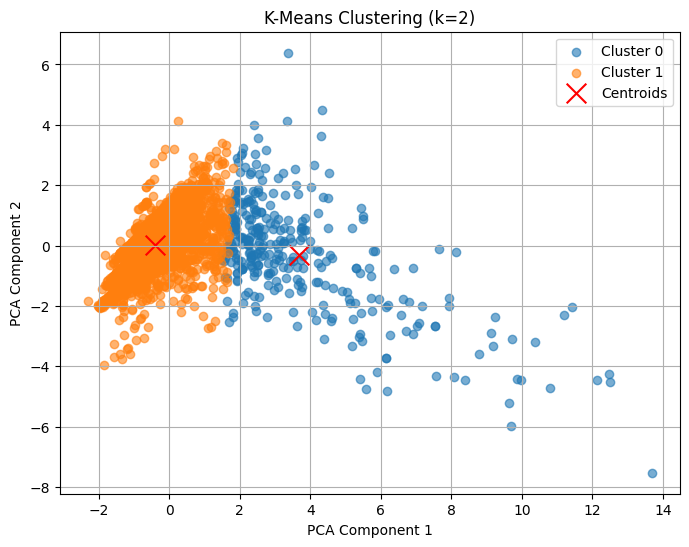

Cluster assignments:
                                Title  Cluster
233   The Good, the Bad and the Ugly        1
831                Wasei Kingu Kongu        1
2659                        Farewell        1
2496                  Rome Adventure        1
3101                  Chinese Zodiac        1
...                              ...      ...
208     The File of the Golden Goose        1
1578                       Hairspray        0
565                           Dr. No        1
313           The King and the Clown        1
601                 Marked for Death        1

[3280 rows x 2 columns]


In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_clusters(X, labels, centroids, title="K-Means Clustering"):
    """Visualize the clusters in 2D using PCA."""
    # Reduce dimensions to 2D for visualization
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    centroids_2d = pca.transform(centroids)

    # Plot each cluster
    plt.figure(figsize=(8, 6))
    for cluster in np.unique(labels):
        cluster_points = X_2d[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.6)

    # Plot centroids
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], color='red', marker='x', s=200, label='Centroids')

    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage with the K-Means function
def preprocess_numeric_features(df, features):
    """Extract and normalize numeric features."""
    X = df[features].values
    X = (X - X.mean(axis=0)) / X.std(axis=0)  # Standardization
    return X

numeric_features = ['Year', 'Runtime', 'Wins', 'Nominations', 'BoxOffice', 'NumGenres', 'NumActors', 'NumLanguages', 'NumCountries']


# Preprocess the dataset
X = preprocess_numeric_features(res, numeric_features)

# Apply K-Means with k=2
k = 2
labels, centroids = k_means_clustering(X, k)

# Add cluster labels to the original dataset
res['Cluster'] = labels

# Plot the clusters
plot_clusters(X, labels, centroids, title="K-Means Clustering (k=2)")

# Print cluster assignments
print("Cluster assignments:\n", res[['Title', 'Cluster']])

### Assesment of the Dataset Difficulty

In [ ]:
# Assuming 'Cluster' and 'Target' columns exist in your DataFrame
matching_rows = (res['Cluster'] == res['Target']).sum()

print(f"Number of matching rows where Cluster and Target are equal: {matching_rows}")

Number of matching rows where Cluster and Target are equal: 954


## Task 2: Supervised Learning

### 2.1. Logistic Regression

In [21]:
new_df = pd.DataFrame()
new_df = res.drop(['Title', 'Train/Test', 'Genres'], axis=1)
new_df

,Year,Runtime,Wins,Nominations,BoxOffice,NumGenres,NumActors,NumLanguages,NumCountries,Target,Cluster
233,0.482143,0.034100,0.007843,0.017241,0.026797,3,3,2,41,1,1
831,0.187500,0.005747,0.000000,0.000000,0.000000,3,3,2,5,0,1
2659,0.866071,0.021648,0.000000,0.000000,0.000000,3,3,3,6,0,1
2496,0.446429,0.022797,0.000000,0.003448,0.000000,2,3,2,13,0,1
3101,0.892857,0.020881,0.027451,0.044828,0.000000,3,3,5,16,0,1
...,...,...,...,...,...,...,...,...,...,...,...
208,0.508929,0.020115,0.000000,0.000000,0.000148,3,3,1,14,0,1
1578,0.848214,0.022414,0.082353,0.155172,0.126990,3,3,1,37,0,0
565,0.446429,0.021073,0.015686,0.013793,0.017153,3,3,3,29,1,1
313,0.830357,0.022797,0.054902,0.051724,0.000000,2,3,1,11,1,1


In [23]:
def logistic_regression_analysis(res):
    import numpy as np
    import pandas as pd
    import time
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score


    X = res.iloc[:, :-1].values.astype(float)  # Features (all columns except last)
    y = res.iloc[:, -1].values.astype(float)   # Target (last column)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Logistic Regression from scratch
    class LogisticRegressionScratch:
        def __init__(self, learning_rate=0.01, epochs=1000, regularization=None, reg_lambda=0.01):
            self.learning_rate = learning_rate
            self.epochs = epochs
            self.regularization = regularization
            self.reg_lambda = reg_lambda

        def sigmoid(self, z):
            return 1 / (1 + np.exp(-z))

        def compute_loss(self, h, y):
            m = len(y)
            if self.regularization == 'l2':
                reg_term = (self.reg_lambda / (2 * m)) * np.sum(np.square(self.weights))
            else:
                reg_term = 0
            return -1 / m * (np.dot(y, np.log(h)) + np.dot((1 - y), np.log(1 - h))) + reg_term

        def fit(self, X, y):
            # Ensure X and y are NumPy arrays
            X = np.array(X, dtype=float)
            y = np.array(y, dtype=float)

            m, n = X.shape
            self.weights = np.zeros(n, dtype=float)
            self.bias = 0.0
            self.losses = []

            for epoch in range(self.epochs):
                # Forward propagation
                z = np.dot(X, self.weights) + self.bias
                h = self.sigmoid(z)

                # Compute loss
                loss = self.compute_loss(h, y)
                self.losses.append(loss)

                # Backward propagation
                dw = (1 / m) * np.dot(X.T, (h - y))
                db = (1 / m) * np.sum(h - y)

                # Apply regularization if specified
                if self.regularization == 'l2':
                    dw += (self.reg_lambda / m) * self.weights

                # Update weights and bias
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

                # Stopping criteria (if loss does not improve significantly)
                if epoch > 1 and abs(self.losses[-1] - self.losses[-2]) < 1e-6:
                    break

        def predict(self, X):
            X = np.array(X, dtype=float)  # Ensure X is a NumPy array
            z = np.dot(X, self.weights) + self.bias
            return (self.sigmoid(z) >= 0.5).astype(int)

    # Train logistic regression from scratch
    start_time = time.time()
    log_reg_scratch = LogisticRegressionScratch(learning_rate=0.1, epochs=1000, regularization='l2', reg_lambda=0.1)
    log_reg_scratch.fit(X_train, y_train)
    scratch_training_time = time.time() - start_time

    # Predictions and accuracy
    y_train_pred_scratch = log_reg_scratch.predict(X_train)
    y_test_pred_scratch = log_reg_scratch.predict(X_test)

    train_accuracy_scratch = accuracy_score(y_train, y_train_pred_scratch)
    test_accuracy_scratch = accuracy_score(y_test, y_test_pred_scratch)

    # Logistic Regression using Scikit-Learn
    start_time = time.time()
    log_reg_sklearn = LogisticRegression(max_iter=1000, penalty='l2', C=1/0.1, solver='lbfgs')
    log_reg_sklearn.fit(X_train, y_train)
    sklearn_training_time = time.time() - start_time

    # Predictions and accuracy
    y_train_pred_sklearn = log_reg_sklearn.predict(X_train)
    y_test_pred_sklearn = log_reg_sklearn.predict(X_test)

    train_accuracy_sklearn = accuracy_score(y_train, y_train_pred_sklearn)
    test_accuracy_sklearn = accuracy_score(y_test, y_test_pred_sklearn)

    # Comparison of performance and runtime
    results = {
        "Model": ["From Scratch", "Scikit-Learn"],
        "Train Accuracy": [train_accuracy_scratch, train_accuracy_sklearn],
        "Test Accuracy": [test_accuracy_scratch, test_accuracy_sklearn],
        "Training Time (s)": [scratch_training_time, sklearn_training_time]
    }

    results_df = pd.DataFrame(results)

    #import ace_tools as tools
    #tools.display_dataframe_to_user(name="Logistic Regression Performance Comparison", dataframe=results_df)

    return results_df

# Now the corrected function is ready to be called with your `res` dataframe!


In [24]:
results = logistic_regression_analysis(new_df)
results

<ipython-input-23-2bfbd785b888>:33: RuntimeWarning: divide by zero encountered in log
  return -1 / m * (np.dot(y, np.log(h)) + np.dot((1 - y), np.log(1 - h))) + reg_term


,Model,Train Accuracy,Test Accuracy,Training Time (s)
0,From Scratch,0.843206,0.864837,0.593757
1,Scikit-Learn,0.991289,0.983740,0.083957


###2.3. Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import pandas as pd
import time

def random_forest_analysis(res):
    """
    Perform Random Forest analysis with hyperparameter tuning and evaluation.

    Parameters:
        res (DataFrame): The dataset with features and target.

    Returns:
        DataFrame: A table with the results of the analysis.
    """
    # Split data into features and target
    X = res.iloc[:, :-1].values  # Features (all columns except last)
    y = res.iloc[:, -1].values   # Target (last column)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 3(a) Determine the number of trees using 5-fold cross-validation
    num_trees_options = [10, 50, 100, 200, 500]
    best_score = 0
    best_num_trees = 0

    for num_trees in num_trees_options:
        rf = RandomForestClassifier(n_estimators=num_trees, random_state=42)
        scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_num_trees = num_trees

    # Train the final Random Forest model with the best number of trees
    start_time = time.time()
    final_rf = RandomForestClassifier(n_estimators=best_num_trees, random_state=42)
    final_rf.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Evaluate the model on training and test sets
    train_accuracy = final_rf.score(X_train, y_train)
    test_accuracy = final_rf.score(X_test, y_test)

    # Results
    results = {
        "Best Num Trees": best_num_trees,
        "Cross-Validation Accuracy": best_score,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Training Time (s)": training_time
    }

    # Convert results to a DataFrame for better presentation
    results_df = pd.DataFrame([results])
    return results_df

# To run the function, ensure your dataset (res) is properly cleaned and prepared
# Example:
# rf_results = random_forest_analysis(res)
# print(rf_results)


In [26]:

rf_results = random_forest_analysis(new_df)

# Display the results
print(rf_results)


   Best Num Trees  Cross-Validation Accuracy  Train Accuracy  Test Accuracy  \
0              50                   0.982575             1.0       0.978659   

   Training Time (s)  
0           0.250907  


### 2.4 K-nearest neighbours

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score
import time

class KNearestNeighborsScratch:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        """Store the training data."""
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        """Predict the class labels for the input data X."""
        X = np.array(X)
        predictions = []

        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            predictions.append(np.bincount(k_nearest_labels).argmax())

        return np.array(predictions)

    def set_k(self, X, y, k_values, cv=5):
        """Determine the best k value using cross-validation."""
        best_k = 0
        best_score = 0
        k_fold = KFold(n_splits=cv, shuffle=True, random_state=42)

        for k in k_values:
            self.k = k
            scores = []

            for train_idx, val_idx in k_fold.split(X):
                self.fit(X[train_idx], y[train_idx])
                predictions = self.predict(X[val_idx])
                score = accuracy_score(y[val_idx], predictions)
                scores.append(score)

            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_k = k

        self.k = best_k
        return best_k, best_score

# Implementation of the analysis
def knn_analysis(res):
    # Prepare the dataset
    X = res.iloc[:, :-1].values  # Features (all columns except last)
    y = res.iloc[:, -1].values  # Target (last column)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Instantiate k-NN and determine the best k
    k_values = [1, 3, 5, 7, 9]
    knn = KNearestNeighborsScratch()

    start_time = time.time()
    best_k, best_cv_score = knn.set_k(X_train, y_train, k_values)
    knn_training_time = time.time() - start_time

    # Train the final model
    knn.fit(X_train, y_train)

    # Evaluate on training and test sets
    train_predictions = knn.predict(X_train)
    test_predictions = knn.predict(X_test)

    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    # Results
    results = {
        "Best k": best_k,
        "Cross-Validation Accuracy": best_cv_score,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Training Time (s)": knn_training_time
    }

    return pd.DataFrame([results])




In [28]:
knn_results = knn_analysis(new_df)
print(knn_results)

   Best k  Cross-Validation Accuracy  Train Accuracy  Test Accuracy  \
0       1                   0.943815             1.0       0.939024   

   Training Time (s)  
0           2.875225  


### svm

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import time
from cvxopt import matrix, solvers

class SVMFromScratch:
    def __init__(self, C=1):
        self.C = C

    def fit(self, X, y):
        m, n = X.shape

        # Prepare matrices for quadratic programming
        y = y.reshape(-1, 1) * 1.0
        X_y = X * y
        P = matrix(np.dot(X_y, X_y.T))
        q = matrix(-np.ones((m, 1)))
        G = matrix(np.vstack((-np.eye(m), np.eye(m))))
        h = matrix(np.vstack((np.zeros((m, 1)), np.ones((m, 1)) * self.C)))
        A = matrix(y.reshape(1, -1))
        b = matrix(0.0)

        # Solve QP problem
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x']).flatten()

        # Support vectors
        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y[sv].flatten()

        # Compute weights and bias
        self.w = np.sum(self.alphas[:, None] * self.sv_y[:, None] * self.sv_X, axis=0)
        self.b = np.mean(self.sv_y - np.dot(self.sv_X, self.w))

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

def sklearn_svm_analysis(res):
    # Prepare dataset
    X = res.iloc[:, :-1].values  # Features from all columns except the last
    y = res.iloc[:, -1].values  # Target from the last column

    # Split dataset into training and testing sets (70/30 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define hyperparameters for different kernels
    hyperparameters = {
        'rbf': {'C': [0.001, 0.01, 0.1, 1], 'gamma': [0.001, 0.01, 0.1, 1]},
        'poly': {'C': [0.001, 0.01, 0.1, 1], 'degree': [2, 3], 'gamma': [0.001, 0.01], 'coef0': [0, 1]}
    }

    # Function for hyperparameter search using GridSearchCV
    def svm_hyperparameter_search(kernel_type, hyperparameters):
        classifier = SVC(kernel=kernel_type, random_state=42)  # Define the SVC model
        search = GridSearchCV(classifier, hyperparameters[kernel_type], cv=5, scoring='accuracy', verbose=1)
        start_time = time.time()  # Record the start time
        search.fit(X_train, y_train)  # Perform grid search on the training data
        search_time = time.time() - start_time  # Calculate time taken
        return search.best_params_, search.best_score_, search_time

    # Perform optimization for RBF kernel
    print("Starting optimization for RBF kernel:")
    rbf_best_params, rbf_best_score, rbf_search_time = svm_hyperparameter_search('rbf', hyperparameters)
    print(f"RBF Kernel Optimal Parameters: {rbf_best_params}, Cross-Validation Score: {rbf_best_score}, Grid Search Time: {rbf_search_time}s")

    # Perform optimization for Polynomial kernel
    print("Starting optimization for Polynomial kernel:")
    poly_best_params, poly_best_score, poly_search_time = svm_hyperparameter_search('poly', hyperparameters)
    print(f"Polynomial Kernel Optimal Parameters: {poly_best_params}, Cross-Validation Score: {poly_best_score}, Grid Search Time: {poly_search_time}s")

    # Evaluate the best model from both kernels
    best_kernel, best_params = ('rbf', rbf_best_params) if rbf_best_score > poly_best_score else ('poly', poly_best_params)
    final_model = SVC(kernel=best_kernel, **best_params, random_state=42)
    final_model.fit(X_train, y_train)

    # Evaluate final model on train and test sets
    train_accuracy = final_model.score(X_train, y_train)
    test_accuracy = final_model.score(X_test, y_test)

    # Results
    results = {
        "Best Kernel": best_kernel,
        "Best Parameters": best_params,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "RBF Grid Search Time (s)": rbf_search_time,
        "Polynomial Grid Search Time (s)": poly_search_time
    }

    return pd.DataFrame([results])

# Example for discussion and runtime comparison:
def compare_svm_methods(res):
    # Prepare dataset
    X = res.iloc[:, :-1].values
    y = res.iloc[:, -1].values
    y = np.where(y == 0, -1, 1)  # Convert to -1, 1 for scratch implementation

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # SVM from scratch
    start_time = time.time()
    svm_scratch = SVMFromScratch(C=1)
    svm_scratch.fit(X_train, y_train)
    scratch_time = time.time() - start_time

    y_train_pred_scratch = svm_scratch.predict(X_train)
    y_test_pred_scratch = svm_scratch.predict(X_test)

    train_accuracy_scratch = accuracy_score(y_train, y_train_pred_scratch)
    test_accuracy_scratch = accuracy_score(y_test, y_test_pred_scratch)

    # Scikit-learn SVM
    results_sklearn = sklearn_svm_analysis(res)

    # Combine results
    scratch_results = {
        "Model": "SVM from Scratch",
        "Train Accuracy": train_accuracy_scratch,
        "Test Accuracy": test_accuracy_scratch,
        "Training Time (s)": scratch_time
    }

    sklearn_results = {
        "Model": "Scikit-learn SVM",
        "Train Accuracy": results_sklearn.iloc[0]['Train Accuracy'],
        "Test Accuracy": results_sklearn.iloc[0]['Test Accuracy'],
        "Training Time RBF (s)": results_sklearn.iloc[0]['RBF Grid Search Time (s)'],
        "Training Time Polynomial (s)": results_sklearn.iloc[0]['Polynomial Grid Search Time (s)']

    }

    return pd.DataFrame([scratch_results, sklearn_results])



In [ ]:

svm_comparison_results = compare_svm_methods(new_df)
print(svm_comparison_results)


     pcost       dcost       gap    pres   dres
 0: -1.6521e+03 -8.9788e+03  6e+04  4e+00  2e-11
 1: -1.0613e+03 -7.1552e+03  1e+04  6e-01  1e-11
 2: -9.8299e+02 -2.5363e+03  2e+03  2e-14  1e-11
 3: -1.1372e+03 -1.7121e+03  6e+02  1e-15  8e-12
 4: -1.1706e+03 -1.6011e+03  4e+02  2e-14  7e-12
 5: -1.2069e+03 -1.4768e+03  3e+02  1e-14  8e-12
 6: -1.2174e+03 -1.4422e+03  2e+02  1e-14  7e-12
 7: -1.2185e+03 -1.4415e+03  2e+02  2e-14  8e-12
 8: -1.2481e+03 -1.3522e+03  1e+02  4e-14  8e-12
 9: -1.2523e+03 -1.3413e+03  9e+01  7e-15  7e-12
10: -1.2548e+03 -1.3339e+03  8e+01  2e-14  8e-12
11: -1.2678e+03 -1.3054e+03  4e+01  2e-14  8e-12
12: -1.2706e+03 -1.3000e+03  3e+01  2e-14  8e-12
13: -1.2750e+03 -1.2916e+03  2e+01  8e-15  8e-12
14: -1.2769e+03 -1.2884e+03  1e+01  2e-15  8e-12
15: -1.2791e+03 -1.2849e+03  6e+00  2e-15  8e-12
16: -1.2801e+03 -1.2834e+03  3e+00  2e-14  8e-12
17: -1.2809e+03 -1.2823e+03  1e+00  7e-15  9e-12
18: -1.2812e+03 -1.2818e+03  6e-01  6e-15  9e-12
19: -1.2814e+03 -1.28

In [ ]:
best_results = sklearn_svm_analysis(new_df)
best_results

Starting optimization for RBF kernel:
Fitting 5 folds for each of 16 candidates, totalling 80 fits
RBF Kernel Optimal Parameters: {'C': 1, 'gamma': 1}, Cross-Validation Score: 0.6746556786965994, Grid Search Time: 13.23220181465149s
Starting optimization for Polynomial kernel:
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Polynomial Kernel Optimal Parameters: {'C': 1, 'coef0': 1, 'degree': 3, 'gamma': 0.01}, Cross-Validation Score: 0.7112342521549684, Grid Search Time: 46.46709966659546s


,Best Kernel,Best Parameters,Train Accuracy,Test Accuracy,RBF Grid Search Time (s),Polynomial Grid Search Time (s)
0,poly,"{'C': 1, 'coef0': 1, 'degree': 3, 'gamma': 0.01}",0.716899,0.712398,13.232202,46.4671
